In [7]:
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import time

class AdvancedViz():

    def __init__(self, data_path = "../ift6758/data/tidy/all_seasons_combined.csv", rink_img = "../figures/nhl_rink.png"):
        self._data = pd.read_csv(data_path).dropna(subset=['x_coord', 'y_coord'])
        self._rink_img = mpimg.imread(rink_img)
        self._n_xbins = 20
        self._n_ybins = 10
        self._smoothing_factor = 10
        
        self._data.loc[self._data["x_coord"] > 0, "y_coord"] *= -1
        self._data["x_coord"] = np.abs(self._data["x_coord"])
        
        self._data["xbin"] = np.digitize(self._data["x_coord"], np.linspace(-100, 100, self._n_xbins+1)) - 1
        self._data["ybin"] = np.digitize(self._data["y_coord"], np.linspace(-42.5, 42.5, self._n_ybins+1)) - 1
        
        self._rink_width_feet = 200.0
        self._rink_height_feet = 85.0
        self._rink_width_pixel = self._rink_img.shape[1]
        self._rink_height_pixel = self._rink_img.shape[0]
        
    # assuming each game lasts 60 minutes
    # returns league average shot per hour in a region of the rink
    # if a team is specified, return the average for that team
    def _avg_shot_per_hour(self, season, xbin, ybin, team=None):
        df = self._data
        if not team:
            df = df[(df["season"] == season) & (df["xbin"] == xbin) & (df["ybin"] == ybin)]
            total_shots = df.shape[0]*0.5
            total_games = pd.unique(self._data[self._data["season"] == season]["game_id"]).shape[0]
        else:
            df = df[(df["season"] == season) & (df["xbin"] == xbin) & (df["ybin"] == ybin) & (df["team_name"] == team)]
            total_shots = df.shape[0]
            total_games = pd.unique(self._data[(self._data["season"] == season) & (self._data["team_name"] == team)]["game_id"]).shape[0]
        if total_games == 0:
            return 0
        return total_shots/total_games

    # map rink coords to pixel coords
    def _feet_to_pixel(self, x, axisName):
        if axisName == "x":
            return (x*self._rink_width_pixel/self._rink_width_feet) + self._rink_width_pixel/2.0
        elif axisName == "y":
            return -(x*self._rink_height_pixel/self._rink_height_feet) + self._rink_height_pixel/2.0

    # map pixel coords to rink coords
    def _pixel_to_feet(self, x, axisName):
        if axisName == "x":
            return (x*self._rink_width_feet/self._rink_width_pixel) - self._rink_width_feet/2.0
        elif axisName == "y":
            return -(x*self._rink_height_feet/self._rink_height_pixel) + self._rink_height_feet/2.0

    # generate heatmap matrix
    def _generate_heatmap(self, team, season, variance=0.12):

        # returns list of distances from x to yi for each yi in y
        def cartesian_mat(x,y):
            return np.sum((x-y)**2, axis=1)**0.5

        # gaussian kernel for smoothing
        def gaussian(d2, variance):
            coef = 1 / (2 * np.pi * variance)
            return coef * np.exp(-d2 / (2 * variance))

        # build initial heatmap
        heatmap = np.zeros((self._n_xbins, self._n_ybins))
        for x, y in np.ndindex(heatmap.shape):
            team_avg = self._avg_shot_per_hour(season, x, y, team)
            avg = self._avg_shot_per_hour(season, x, y)
            heatmap[x,y] = team_avg - avg

        # build finer grid
        x, y = np.indices(heatmap.shape)
        heatmap = np.column_stack((x.ravel(), y.ravel(), heatmap.ravel()))
        s = self._smoothing_factor
        heatmap_smooth = np.repeat(heatmap, s**2, axis=0)
        offsets = np.array([[i/s, j/s, 0] for i in range(s) for j in range(s)])
        heatmap_smooth += np.tile(offsets, (heatmap.shape[0], 1))
        heatmap_smooth[:,2] = 0
        
        # compute the smoothed heatmap
        for x in heatmap_smooth:
            distance_mat = cartesian_mat(x[:2], heatmap[:,0:2])
            weights = gaussian(distance_mat,variance)
            x[2] = np.sum(heatmap[:,2]*weights) / np.sum(weights)

        return heatmap_smooth
            
    def draw_heatmap(self, team, season, variance=0.12):

        # draw rectangle with top left corner at (x,y) in grid coords
        def drawCell(x, y, value, vmax = 1, vmin = -1):
            rect_xSize = self._rink_img.shape[1]/(self._n_xbins*self._smoothing_factor)
            rect_ySize = self._rink_img.shape[0]/(self._n_ybins*self._smoothing_factor)
            rect_x = x*rect_xSize*self._smoothing_factor
            rect_y = y*rect_ySize*self._smoothing_factor
            norm = (value - vmin) / (vmax - vmin)
            norm = np.clip(norm, 0, 1)
            cmap = mcolors.LinearSegmentedColormap.from_list(
                "blue_white_red", ["blue", "white", "red"]
            )
            color = cmap(norm)
            rect = patches.Rectangle((rect_x, rect_y), rect_xSize, rect_ySize, linewidth = 0, edgecolor = color, facecolor = color, alpha = 0.3 + abs(norm - 0.5))
            plt.gca().add_patch(rect)
            
        plt.rcParams['figure.figsize'] = (10, 6)
        plt.imshow(self._rink_img)
        
        # set tick values to represent rink coords
        plt.xlabel("feet")
        plt.ylabel("feet")
        xticks_pixel = np.linspace(0, self._rink_width_pixel, 9)
        yticks_pixel = np.linspace(0, self._rink_height_pixel, 5)
        xticks_feet = [self._pixel_to_feet(x, "x") for x in np.linspace(0, self._rink_width_pixel, 9)]
        yticks_feet = [self._pixel_to_feet(y, "y") for y in np.linspace(0, self._rink_height_pixel, 5)]
        plt.xticks(xticks_pixel, xticks_feet)
        plt.yticks(yticks_pixel, yticks_feet)

        # draw heatmap
        heatmap = self._generate_heatmap(team, season, variance)
        vmin = np.min(heatmap[:,2])
        vmax = np.max(heatmap[:,2])
        for x in heatmap:
            drawCell(x[0], x[1], x[2], vmax, vmin)

        # show figure
        #plt.xlim(self._rink_width_pixel/2.0, self._rink_width_pixel)
        plt.show()
        

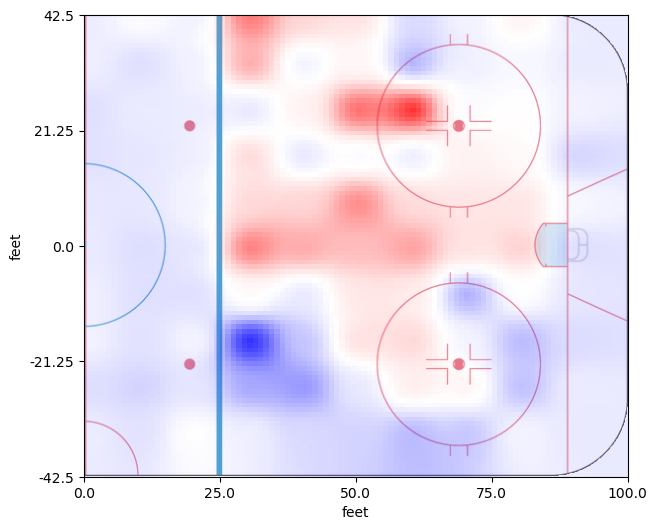

In [4]:
viz = AdvancedViz()
team = "Colorado Avalanche"
viz.draw_heatmap(team, 2020, 0.13)
#viz.draw_heatmap(team, 2020, 0.2)
